# 1. Import libraries

In [2]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# 2. Load data

In [3]:
# 1. Load datasets. For metadata dataset, drop both columns, and 
credits = pd.read_csv('the-movies-datasets\credits.csv')
keywords = pd.read_csv('the-movies-datasets\keywords.csv')
movies = pd.read_csv('the-movies-datasets\movies_metadata.csv').drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).drop([19730, 29503, 35587]) # Incorrect data type

# 2. Retype movies['id'] as integer
movies['id'] = movies['id'].astype('int64')

# 3. Merge 'movies' with 'keywords' & 'credits' on 'id'
df1 = movies.merge(keywords, on='id').merge(credits, on='id')

In [4]:
df = df1.copy()

In [6]:
# 1. Create get_text function
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

# 2. Create wrangle function
def wrangle(df):
    # 1. Retype columns
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['budget'] = df['budget'].astype('float64')
    df['popularity'] = df['popularity'].astype('float64')

    # 2. Fill null for 'original_language', 'runtime', 'tagline'
    df['original_language'] = df['original_language'].fillna('')
    df['runtime'] = df['runtime'].fillna(0)
    df['tagline'] = df['tagline'].fillna('')

    # 3. Besides, drop all other null values
    df.dropna(inplace=True)

    # 4. Apply function get_text for features
    df['genres'] = df['genres'].apply(get_text)
    df['production_companies'] = df['production_companies'].apply(get_text)
    df['production_countries'] = df['production_countries'].apply(get_text)
    df['crew'] = df['crew'].apply(get_text)
    df['spoken_languages'] = df['spoken_languages'].apply(get_text)
    df['keywords'] = df['keywords'].apply(get_text)
    df['actors'] = df['cast'].apply(get_text)
    df['characters'] = df['cast'].apply(get_text, obj='character')

    # 4. Drop rows that have duplicated 'original_title'
    df = df[(df['popularity'] != df['popularity'].max())]
    df = df[~df['original_title'].duplicated()]
    df.drop('cast', axis=1, inplace=True)
    df = df.reset_index(drop=True)

    return df

In [7]:
# Run wrangle function on dataframe
df = wrangle(df)

In [7]:
# Save to csv file
# df.to_csv('cleaned_movies_data.csv')

# 3. Visualizations

(0.0, 2.0, 0.9, 1.2)

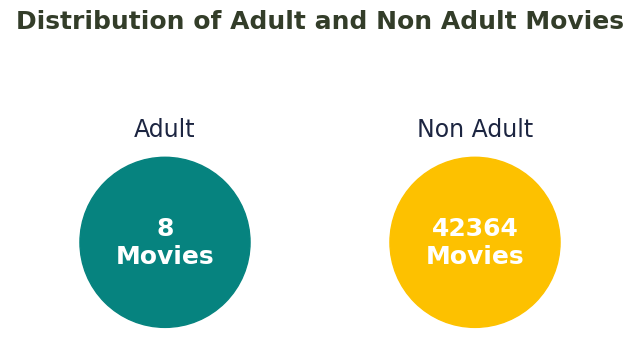

In [8]:
# 1. Different number of Adult and Non Adult movies

# Cái này không phải create chart như bình thường. Mà là vẽ 1 illustration, dựa trên function chart
# Đầu tiên, tạo 1 cái khung với 2 cục hình tròn, size = 15000, khác màu
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100']) # Create 2 point x và y, với các vị trí như vậy, size là 15000
plt.xlim(0,2) # Set điểm nhìn, trên x là 0 đến 2
plt.ylim(0.9,1.2) # Set điểm nhìn, trên y là 0.9 đến 1.2


plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29') # Set chart title
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white') # Create text = length of df with True for Adult, position compatible with circle created above
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white') # Create text = length of df with False for Adult, position compatible with circle created above
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541') # Create text
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541') # Create text

plt.axis('off') # Turn off the axes

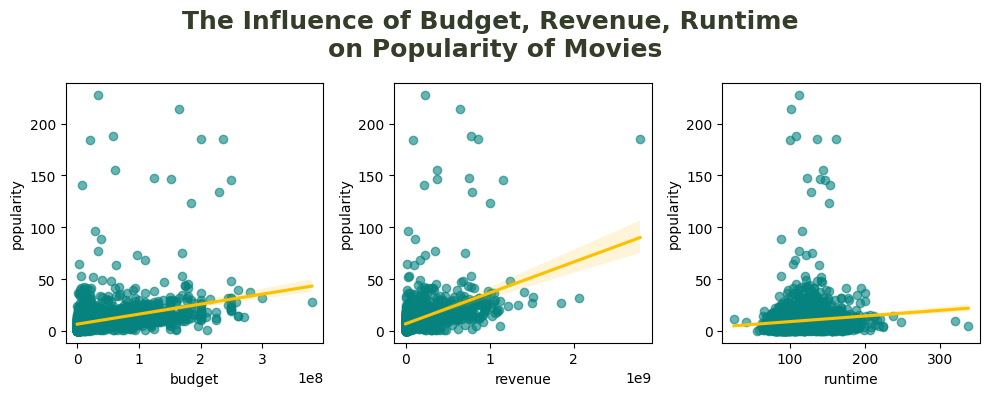

In [9]:
# 2. Influence of Budget, Revenue, and Runtime on Popularity of movies

# Lấy data nào khác 0
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0) & (df['runtime'] != 0)]

# 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

plt.suptitle('The Influence of Budget, Revenue, Runtime \non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue', 'runtime']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

(-1.25, 1.25, -1.25, 1.25)

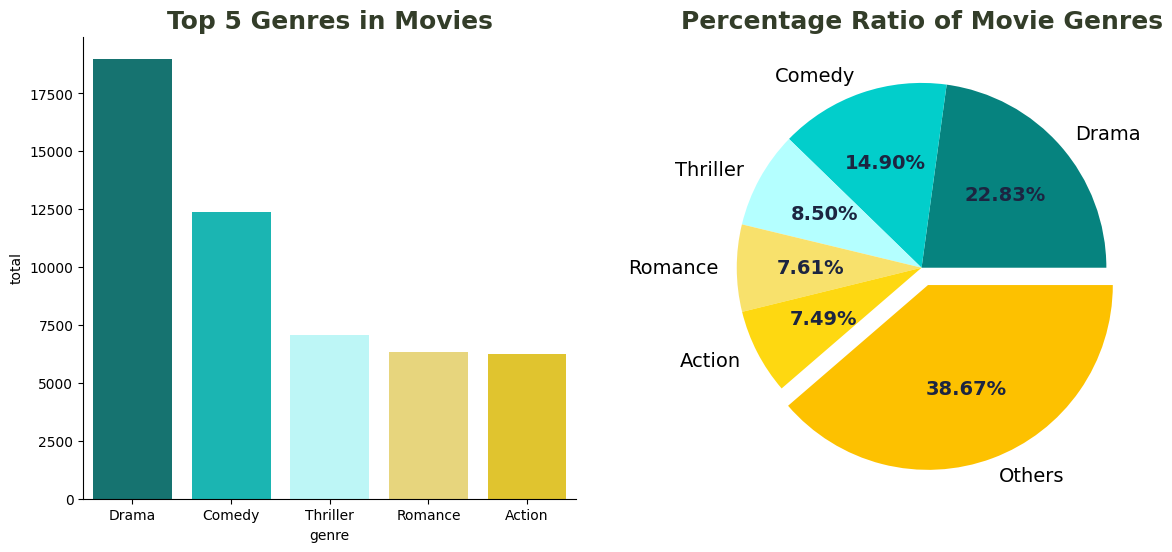

In [40]:
# 3. Check on genres (Top 5 most popular genres and percent of each genres)

# 3.1. Create 1 list, append tất cả elements vào cái list này (Để xuống dưới đếm). 
# Giống như một dạng Find all elements, xong count
# However, still does not understand why without split, it treat each character as an objsect
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

# 3.2. Create subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# 3.3. Create data plot, với 5 most common data values in genres_list
# Khúc này dùng Counter để count hashable object thì phải
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

# 3.4. Create another data plot, with data transpose @@ 
# Khúc này không hiểu tại sao phải transpose, nếu không transpose thì sẽ bị lỗi.

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])


for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')
axes[1].axis('off')

Text(0.5, 1.0, 'Total Released Movie by Date')

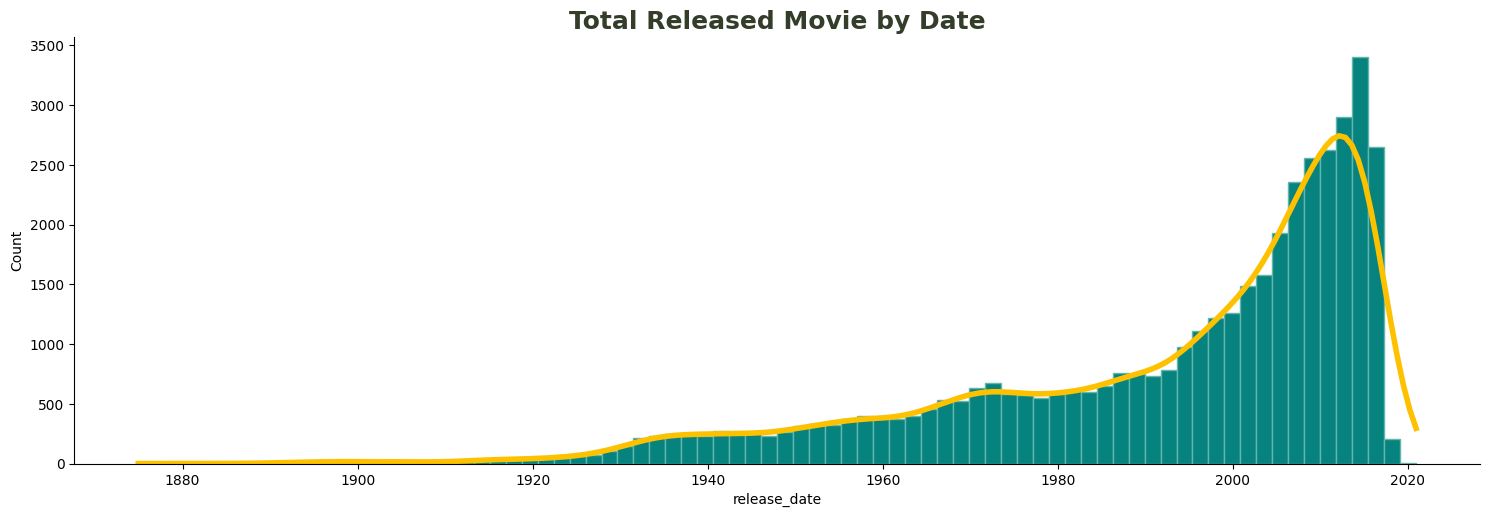

In [60]:
# 4. Distribution of movies release

# Count number of movies released
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 4}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

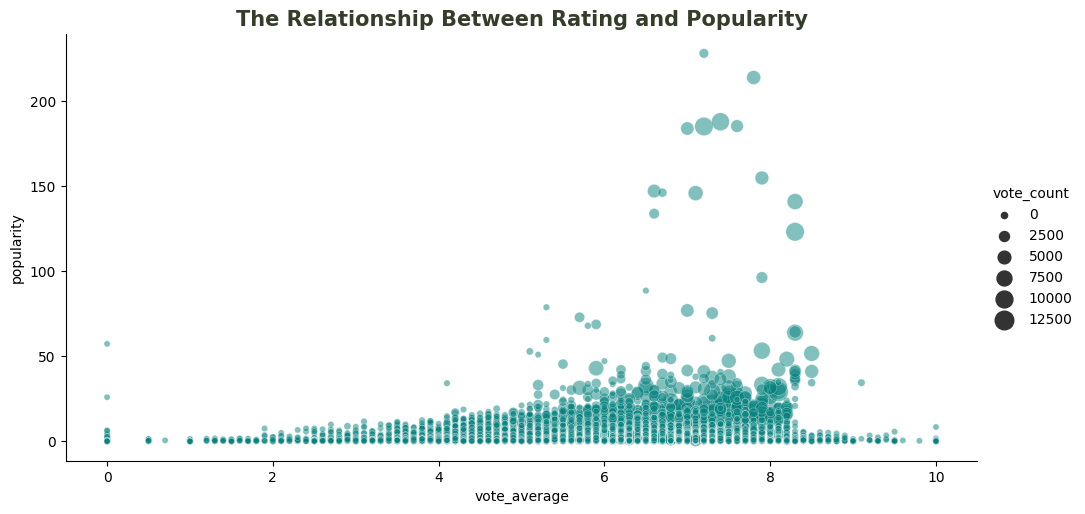

In [61]:
# 5. Relationship between rating and popularity

sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

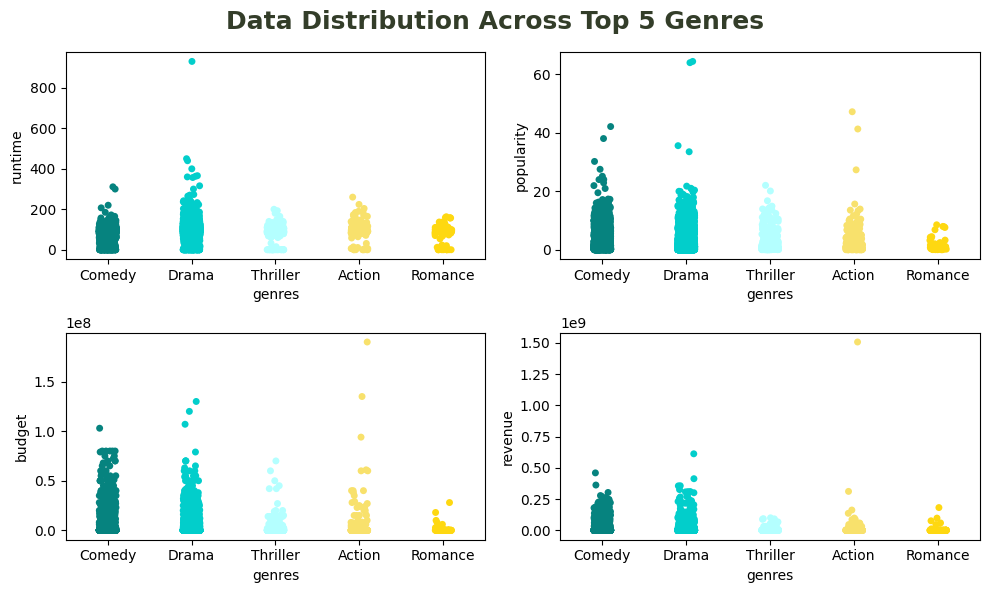

In [62]:
# 6. Data distribution across top 5 genres

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

<Axes: title={'center': 'Correlation of Movie Features\n'}>

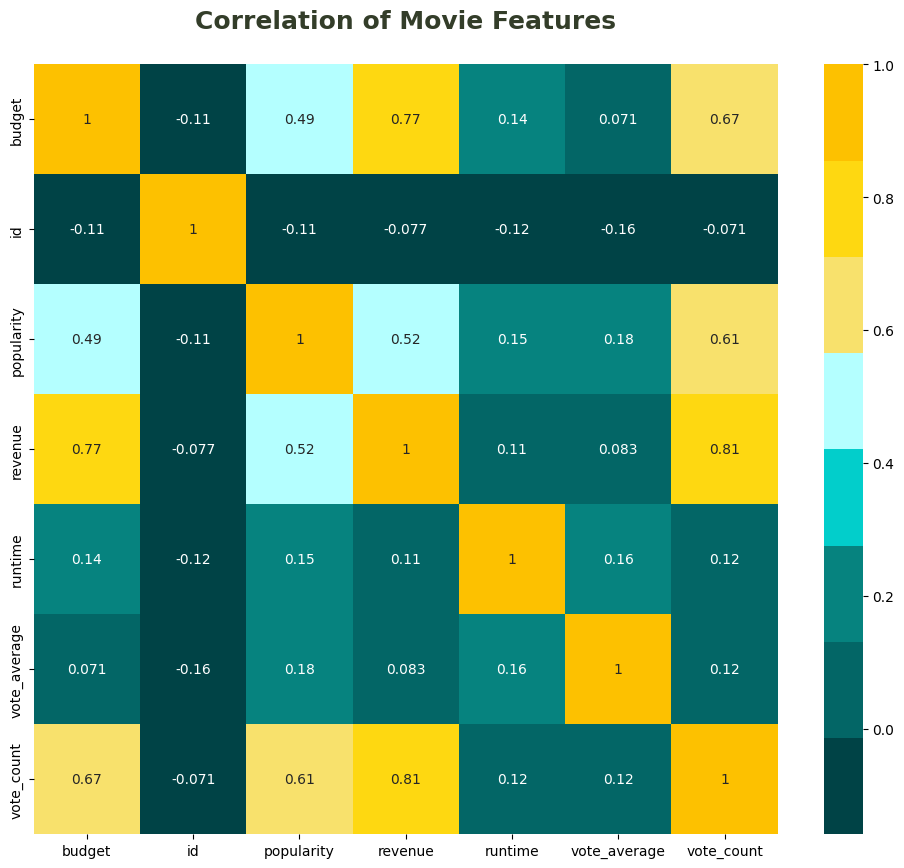

In [68]:
# 7. Heatmap of movie features

plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])
# sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

# Hybrid Recommender System


In [69]:
# 1. Formular for system

R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [101]:
# 2. Scaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [102]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [103]:
# 3. Create weight dataframe
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Big Hero 6,0.937804,0.827562,0.893707
Baby Driver,1.000000,0.727736,0.891094
Guardians of the Galaxy Vol. 2,0.812739,0.794867,0.805590
Deadpool,0.823831,0.764658,0.800162
Avatar,0.811598,0.732643,0.780016
John Wick,0.806333,0.699477,0.763591
Gone Girl,0.678854,0.843414,0.744678
Pulp Fiction,0.618114,0.908395,0.734227
The Dark Knight,0.540130,0.909124,0.687727


In [104]:
# 4. Create hybrid dataframe

hybrid_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [105]:
# 5. Work with text functions

def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [106]:
# 6. Apply functions to features

hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
hybrid_df['overview'] = hybrid_df['overview'].apply(remove_punc)
hybrid_df['production_companies'] = hybrid_df['production_companies'].apply(separate)
hybrid_df['tagline'] = hybrid_df['tagline'].apply(remove_punc)
hybrid_df['keywords'] = hybrid_df['keywords'].apply(separate)
hybrid_df['crew'] = hybrid_df['crew'].apply(separate)
hybrid_df['characters'] = hybrid_df['characters'].apply(separate)
hybrid_df['actors'] = hybrid_df['actors'].apply(separate)

hybrid_df['bag_of_words'] = ''
hybrid_df['bag_of_words'] = hybrid_df[hybrid_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
hybrid_df.set_index('original_title', inplace=True)

hybrid_df = hybrid_df[['bag_of_words']]
hybrid_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


In [107]:
# 7. Merge/ Transform something @@
 
hybrid_df = weighted_df_sorted[:10000].merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(10000, 29656)

In [108]:
# 8. Cosine similarity
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [126]:
# 9. Predict function

def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    # final_df_sorted[['score', 'similarity', 'final_score']].reset_index()
    return final_df_sorted.reset_index()

In [127]:
# 10. Run function
predict('Titanic')

,original_title,popularity,weighted_average,score,bag_of_words,similarity,final_score
0,Titanic,0.117918,0.780076,0.382781,false drama romance thriller years later a ye...,1.000000,0.814834
1,Avatar,0.811598,0.732643,0.780016,false action adventure fantasy science fiction...,0.251811,0.410272
2,Indiana Jones and the Temple of Doom,0.069298,0.713471,0.326967,false adventure action after arriving in india...,0.406155,0.382398
3,Popstar: Never Stop Never Stopping,0.023178,0.617557,0.260930,false comedy music when his new album fails to...,0.381860,0.345581
4,Anonymous,0.058824,0.573190,0.264571,false drama history thriller set against the b...,0.370530,0.338742
5,Music and Lyrics,0.031560,0.565363,0.245081,false comedy music romance a washed up singer ...,0.361431,0.326526
6,Austin Powers in Goldmember,0.038532,0.522341,0.232056,false comedy crime science fiction the worlds ...,0.363988,0.324408
7,"Hail, Caesar!",0.049297,0.491779,0.226290,false comedy drama mystery tells the comedic t...,0.339698,0.305676
8,Young @ Heart,0.006941,0.572963,0.233350,false documentary documents the true story of ...,0.311783,0.288253
9,Looney Tunes: Back in Action,0.059932,0.477202,0.226840,false animation comedy family bugs bunny and d...,0.312011,0.286460


# 5. Deep Learning

In [129]:
# 1. Load and clean data
ratings_df = pd.read_csv(r'the-movies-datasets\ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 09:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 09:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 09:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 09:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 09:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [130]:
# 2. Subset data

movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [131]:
# 3. Slice and map data?

ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [132]:
# 4. Train - test split

print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 43188


In [133]:
# 5. List users and movies

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42372
Unique users: 671


In [134]:
# 6. Movie models gì đó mà mìn không hiểu...

class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)


In [135]:
# 4. Fill data with model

model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
35/35 [==============================] - 47s 1s/step - root_mean_squared_error: 1.5034 - factorized_top_k/top_1_categorical_accuracy: 2.8571e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factorized_top_k/top_10_categorical_accuracy: 0.0183 - factorized_top_k/top_50_categorical_accuracy: 0.1030 - factorized_top_k/top_100_categorical_accuracy: 0.1726 - loss: 6814.9933 - regularization_loss: 0.0000e+00 - total_loss: 6814.9933
Epoch 2/3
35/35 [==============================] - 50s 1s/step - root_mean_squared_error: 1.0247 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0189 - factorized_top_k/top_10_categorical_accuracy: 0.0447 - factorized_top_k/top_50_categorical_accuracy: 0.2024 - factorized_top_k/top_100_categorical_accuracy: 0.3200 - loss: 6451.7070 - regularization_loss: 0.0000e+00 - total_loss: 6451.7070
Epoch 3/3
35/35 [==============================] - 48s 1s/step - root_mean_squared_error: 0.9897 - fac

In [136]:
# 6. Create prediction function

def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))


In [146]:
# 7. Run recommendation function for user

predict_movie(125, 5)
print('\n')
predict_rating(125,'Schock')

Top 5 recommendations for user 125:

1. Shuang ma lian huan
2. The Chronicles of Riddick: Dark Fury
3. Lola rennt
4. Schock
5. Montag kommen die Fenster


Predicted rating for Schock: 3.1424074172973633


In [138]:
# 8. Examine result

ratings_df[ratings_df['userId'] == '123']

# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['123']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

,original_title,genres,overview
1,Un long dimanche de fiançailles,Drama,"In 1919, Mathilde was 19 years old. Two years ..."
2,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
3,El otro lado de la cama,"Romance, Drama","When Paula leaves her mate Pedro, he misses he..."
4,Scary Movie,Comedy,Following on the heels of popular teen-scream ...
5,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
